In [1]:
# Import necessary libraries
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
train_data  = pd.read_csv("/mnt/d/Dropbox/Kaggler/Loan Prediction/playground-series-s4e10/train.csv")
train = train_data.drop("id", axis=1)
test_data  = pd.read_csv("/mnt/d/Dropbox/Kaggler/Loan Prediction/playground-series-s4e10/test.csv")
test = test_data .drop("id", axis=1)
original = pd.read_csv('/mnt/d/Dropbox/Kaggler/Loan Prediction/playground-series-s4e10/credit_risk_dataset.csv')

In [3]:
class Config:  
    dep_var = 'loan_status'
    n_folds = 5
    seed = 4294
    neighbors = 6

In [4]:
preprocessing = [Categorify, Normalize]
splits = RandomSplitter(valid_pct=0.20, seed=Config.seed)(range_of((train)))
dep_var = Config.dep_var
cont, cat = cont_cat_split(train, dep_var=dep_var)

to = TabularPandas(train, procs=preprocessing, cat_names=cat, cont_names=cont, y_names=dep_var, splits=splits)

In [5]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test)

xs,y = to.train.xs, to.train.y
valid_xs,valid_y = to.valid.xs, to.valid.y
xs.shape, valid_xs.shape

((46916, 11), (11729, 11))

In [6]:
m = RandomForestClassifier(200, min_samples_leaf=5, random_state=Config.seed).fit(xs, y)
# mean_absolute_error(valid_y, m.predict(valid_xs))
print(roc_auc_score(valid_y, m.predict_proba(valid_xs)[:,1]))
# print(roc_auc_score(valid_y.values, m.predict_proba(valid_xs)))

0.9416456025529115


In [7]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
3,cb_person_default_on_file,0.010301
10,cb_person_cred_hist_length,0.016812
4,person_age,0.021105
7,loan_amnt,0.047397
6,person_emp_length,0.049981
1,loan_intent,0.065493
5,person_income,0.089827
8,loan_int_rate,0.118927
0,person_home_ownership,0.119992
2,loan_grade,0.169071


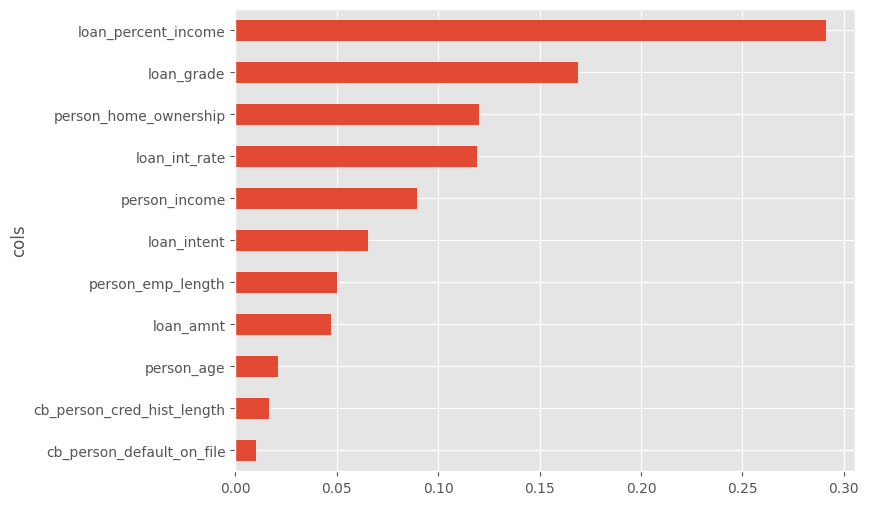

In [8]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(8,6), legend=False)

plot_fi(fi[:30]);

#### Removing Low-Importance Variables

In [9]:
to_keep = fi[fi.imp>0.045].cols
len(to_keep)

8

In [10]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]


m_imp = RandomForestClassifier(200, min_samples_leaf=5, random_state=Config.seed).fit(xs_imp, y)
print(roc_auc_score(valid_y, m_imp.predict_proba(valid_xs_imp)[:,1]))

0.9421196536604665


In [17]:
#print the roc_auc of m and m_imp using descriptive names
print('roc_auc of m:', roc_auc_score(valid_y, m.predict_proba(valid_xs)[:,1]))
print('roc_auc of m_imp:', roc_auc_score(valid_y, m_imp.predict_proba(valid_xs_imp)[:,1]))



roc_auc of m: 0.9416456025529115
roc_auc of m_imp: 0.9421196536604665
